## Domain Modeling in Python (3.9)

### Stock allocation service

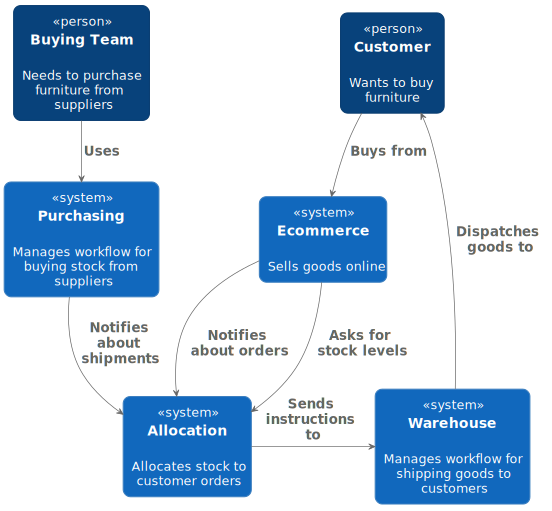

In [1]:
%%plantuml

@startuml allocation
!include images/C4_Context.puml
scale 0.7

System(systema, "Allocation", "Allocates stock to customer orders")

Person(customer, "Customer", "Wants to buy furniture")
Person(buyer, "Buying Team", "Needs to purchase furniture from suppliers")

System(procurement, "Purchasing", "Manages workflow for buying stock from suppliers")
System(ecom, "Ecommerce", "Sells goods online")
System(warehouse, "Warehouse", "Manages workflow for shipping goods to customers")

Rel(buyer, procurement, "Uses")
Rel(procurement, systema, "Notifies about shipments")
Rel(customer, ecom, "Buys from")
Rel(ecom, systema, "Asks for stock levels")
Rel(ecom, systema, "Notifies about orders")
Rel_R(systema, warehouse, "Sends instructions to")
Rel_U(warehouse, customer, "Dispatches goods to")

@enduml

### Business Jargons

- Product: identified by SKU(Stock Keeping Unit)
- Order: identified by an *order reference* and comprises mutliple *order lines*

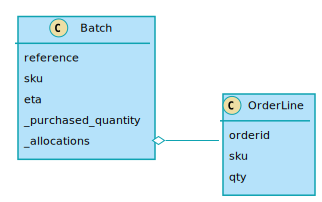

In [2]:
%%plantuml

@startuml

scale 1

left to right direction
hide empty members

class Batch {
    reference
    sku
    eta
    _purchased_quantity
    _allocations
}

class OrderLine {
    orderid
    sku
    qty
}

Batch::_allocations o-- OrderLine

@enduml

# Excercises

- 다음 페이지 참고: https://github.com/cosmicpython/code

**`chapter_01_domain_model_exercise/test_model.py`**

```python

from datetime import date, timedelta
import pytest

# from model import ...

today = date.today()
tomorrow = today + timedelta(days=1)
later = tomorrow + timedelta(days=10)

def test_allocating_to_a_batch_reduces_the_available_quantity():
    pytest.fail('todo')

def test_can_allocate_if_available_greater_than_required():
    pytest.fail('todo')

def test_cannot_allocate_if_available_smaller_than_required():
    pytest.fail('todo')

def test_can_allocate_if_available_equal_to_required():
    pytest.fail('todo')

def test_prefers_warehouse_batches_to_shipments():
    pytest.fail('todo')

def test_prefers_earlier_batches():
    pytest.fail('todo')

```

## Allocation

In [3]:
import pytest

def test(func):
    func()
    return func

In [4]:
@test
def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine('order-ref', "SMALL-TABLE", 2)

    batch.allocate(line)

    assert batch.available_quantity == 18

NameError: name 'Batch' is not defined

In [5]:
from dataclasses import dataclass
from typing import Optional
from datetime import date

@dataclass(frozen=True)  #(1)(2)
class OrderLine:
    orderid: str
    sku: str
    qty: int


class Batch:
    def __init__(
        self, ref: str, sku: str, qty: int, eta: Optional[date]  #(2)
    ):
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self.available_quantity = qty

    def allocate(self, line: OrderLine):
        self.available_quantity -= line.qty  #(3)

In [6]:
@test
def test_allocating_to_a_batch_reduces_the_available_quantity():
    batch = Batch("batch-001", "SMALL-TABLE", qty=20, eta=date.today())
    line = OrderLine('order-ref', "SMALL-TABLE", 2)

    batch.allocate(line)

    assert batch.available_quantity == 18

In [7]:
def make_batch_and_line(sku, batch_qty, line_qty):
    return (
        Batch("batch-001", sku, batch_qty, eta=date.today()),
        OrderLine("order-123", sku, line_qty)
    )

@test
def test_can_allocate_if_available_greater_than_required():
    large_batch, small_line = make_batch_and_line("ELEGANT-LAMP", 20, 2)
    assert large_batch.can_allocate(small_line)

AttributeError: 'Batch' object has no attribute 'can_allocate'

In [8]:
class Batch:
    def __init__(
        self, ref: str, sku: str, qty: int, eta: Optional[date]
    ):
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self._purchased_quantity = qty
        self._allocations = set()  # type: Set[OrderLine]

    def allocate(self, line: OrderLine):
        if self.can_allocate(line):
            self._allocations.add(line)

    def deallocate(self, line: OrderLine):
        if line in self._allocations:
            self._allocations.remove(line)

    @property
    def allocated_quantity(self) -> int:
        return sum(line.qty for line in self._allocations)

    @property
    def available_quantity(self) -> int:
        return self._purchased_quantity - self.allocated_quantity

    def can_allocate(self, line: OrderLine) -> bool:
        return self.sku == line.sku and self.available_quantity >= line.qty

In [9]:
@test
def test_can_allocate_if_available_greater_than_required():
    large_batch, small_line = make_batch_and_line("ELEGANT-LAMP", 20, 2)
    assert large_batch.can_allocate(small_line)

@test
def test_cannot_allocate_if_available_smaller_than_required():
    small_batch, large_line = make_batch_and_line("ELEGANT-LAMP", 2, 20)
    assert small_batch.can_allocate(large_line) is False

@test
def test_can_allocate_if_available_equal_to_required():
    batch, line = make_batch_and_line("ELEGANT-LAMP", 2, 2)
    assert batch.can_allocate(line)

@test
def test_cannot_allocate_if_skus_do_not_match():
    batch = Batch("batch-001", "UNCOMFORTABLE-CHAIR", 100, eta=None)
    different_sku_line = OrderLine("order-123", "EXPENSIVE-TOASTER", 10)
    assert batch.can_allocate(different_sku_line) is False

## Deallocation

In [10]:
@test
def test_can_only_deallocate_allocated_lines():
    batch, unallocated_line = make_batch_and_line("DECORATIVE-TRINKET", 20, 2)
    batch.deallocate(unallocated_line)
    assert batch.available_quantity == 20

In [11]:
@test
def test_allocation_is_idempotent():
    batch, line = make_batch_and_line("ANGULAR-DESK", 20, 2)
    batch.allocate(line)
    batch.allocate(line)
    assert batch.available_quantity == 18

## OrderLine

In [12]:
@dataclass(frozen=True)
class OrderLine:
    orderid: OrderReference
    sku: ProductReference
    qty: Quantity

NameError: name 'OrderReference' is not defined

In [13]:
from typing import NewType

Quantity = NewType("Quantity", int)
Sku = NewType("Sku", str)
Reference = NewType("Reference", str)
OrderReference = NewType("OrderReference", str)
ProductReference = NewType("ProductReference", str)

## Refactored `Batch` using Custom Type

In [14]:
class Batch:
    def __init__(
        self, ref: Reference, sku: str, qty: int, eta: Optional[date]
    ):
        self.reference = ref
        self.sku = sku
        self.eta = eta
        self._purchased_quantity = qty
        self._allocations = set()  # type: Set[OrderLine]

    def allocate(self, line: OrderLine):
        if self.can_allocate(line):
            self._allocations.add(line)

    def deallocate(self, line: OrderLine):
        if line in self._allocations:
            self._allocations.remove(line)

    @property
    def allocated_quantity(self) -> int:
        return sum(line.qty for line in self._allocations)

    @property
    def available_quantity(self) -> int:
        return self._purchased_quantity - self.allocated_quantity

    def can_allocate(self, line: OrderLine) -> bool:
        return self.sku == line.sku and self.available_quantity >= line.qty

## `OrderLine` as a value object

In [15]:
@dataclass(frozen=True)
class OrderLine:
    orderid: OrderReference
    sku: ProductReference
    qty: Quantity

## More examples of value objects

In [16]:
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple

@dataclass(frozen=True)
class Name:
    first_name: str
    surname: str

class Money(NamedTuple):
    currency: str
    value: int

Line = namedtuple('Line', ['sku', 'qty'])

@test
def test_equality():
    assert Money('gbp', 10) == Money('gbp', 10)
    assert Name('Harry', 'Percival') != Name('Bob', 'Gregory')
    assert Line('RED-CHAIR', 5) == Line('RED-CHAIR', 5)

## Math with value objects

In [17]:
fiver = Money('gbp', 5)
tenner = Money('gbp', 10)

@test
def can_add_money_values_for_the_same_currency():
    assert fiver + fiver == tenner

AssertionError: 

In [18]:
class Money(NamedTuple):
    currency: str
    value: int
        
    def __add__(self, rhs: Money):
        if self.currency != rhs.currency: raise ValueError
        return Money(self.currency, self.value + rhs.value)
    
    def __sub__(self, rhs: Money):
        assert self.currency == rhs.currency
        return Money(self.currency, self.value - rhs.value)
    
    def __mul__(self, rhs: int):
        if not isinstance(rhs, (int, float)):
            raise TypeError
        return Money(self.currency, self.value * rhs)            
    
        
fiver = Money('gbp', 5)
tenner = Money('gbp', 10)        

@test
def can_add_money_values_for_the_same_currency():
    assert fiver + fiver == tenner
        
@test
def can_subtract_money_values():
    assert tenner - fiver == fiver

@test
def adding_different_currencies_fails():
    with pytest.raises(ValueError):
        Money('usd', 10) + Money('gbp', 10)

@test
def can_multiply_money_by_a_number():
    assert fiver * 5 == Money('gbp', 25)

@test
def multiplying_two_money_values_is_an_error():
    with pytest.raises(TypeError):
        tenner * fiver    